<a href="https://colab.research.google.com/github/maryamdarei/CNN/blob/main/New_Final_CNN_with_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q grad-cam==1.4.3


     |████████████████████████████████| 7.8 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [42]:
!pip3 install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.8.1%2Bcu101-cp38-cp38-linux_x86_64.whl (763.7 MB)
     |████████████████████████████████| 17.3 MB 5.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utility functions
I like to write my own code, so I have prepared some helper functions to easily train and evaluate the model.

I will be using CrossEntropyLoss in PyTorch, so the model will be trained by using Cross Entropy loss, the implementation already applies logsoftmax to the outputs. So we have to manually apply softmax to model's outputs while evaluating and preparing the predictions.



In [26]:
# utilization
import os
from tqdm import tqdm
from glob import glob

# data manipulation and visualization tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split

# model development and data preparation
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t


# GradCAM implementations and some utility tools
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.backends.cudnn.benchmark = True



### GradCAM

GradCAM stands for Gradient-weighted class activation mappings. In short, we will weight the layer activations by gradients, which will generate a heatmap. Then, we can visualize the parts of the image that has the most impact on the model's outputs. Weighting the layer activations by calculated gradients is not enough though, we have lots of channels in a convolutional layer so we will average the gradients.

I will be using this package to use GradCAM on our networks. The package has different GradCAM implementations, we will generally be using the standard one but I'm including the descriptions of a few of them:

   ##### 1- GradCAM: Weight the 2D activations by the average gradient

   ##### 2- HiResCAM: Like GradCAM but element-wise multiply the activations with the gradients; provably guaranteed faithfulness for certain models

   ##### 3- GradCAMElementWise: Like GradCAM but element-wise multiply the activations with the gradients then apply a ReLU operation before summing

   ##### 4- GradCAM++: Like GradCAM but uses second order gradients

   ##### 5- XGradCAM: Like GradCAM but scale the gradients by the normalized activations

   ##### 6- AblationCAM: Zero out activations and measure how the output drops (this package includes a fast batched implementation)

   ##### 7- ScoreCAM: Perbutate the image by the scaled activations and measure how the output drops

   ##### 8- EigenCAM: Takes the first principle component of the 2D Activations (no class discrimination, but seems to give great results)

   ##### 9- EigenGradCAM: Like EigenCAM but with class discrimination: First principle component of Activations*Grad. Looks like GradCAM, but cleaner

   ##### 10- LayerCAM: Spatially weight the activations by positive gradients. Works better, especially in lower layers

   ##### 11- FullGrad: Computes the gradients of the biases from all over the network, and then sums them

   ##### 12- Deep Feature Factorizations: Non Negative Matrix Factorization on the 2D activations

The descriptions were taken from the github repo

A little helper included below to calculate and plot the GradCAM results:



In [27]:
# CNN Model With PyTorch For Image Classification
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os
import glob
import cv2


In [28]:
def random_split_ratio(dataset, test_size=.2, random_state=None):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    if random_state:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second], generator=torch.Generator().manual_seed(random_state))
    else:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second])

    return first_split, second_split


dataset = "/content/drive/MyDrive/Herbarium Data-2019/small-train-AUG"


In [29]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        sample = sample.permute(1, 2, 0)

        axs[0, i].imshow(sample, cmap='gray')
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()


In [30]:

def evaluate(dataset, model, device='cpu', **dataloader_args):
    dataloader = DataLoader(dataset, **dataloader_args)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()
            
            outs = model(x_batch).detach().cpu()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()
            
            # extend the `preds` and `labels` lists with predictions and true labels
            preds.extend(predictions)
            labels.extend(y_batch)
            
    report = classification_report(labels, preds, digits = 3)
    print(report)
    return report

def train_cv(model_, loss_fn_, optimizer_, dataset, batch_size=256, device='cpu', cv=5, epochs=10, random_state=None, **opt_args):
    training_losses = []
    validation_losses = [] 
    fold_models = []
    
    # define a pseudo number generator and seed it manually if random_state is given
    if random_state:
        gen = torch.Generator().manual_seed(random_state)
    else:
        gen = None
        
    kfold = KFold(n_splits=cv, random_state=random_state, shuffle=True)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):
        fold_training_losses = []
        fold_validation_losses = []
        
        print("CURRENT FOLD:", fold+1)
        
        train_sampler = SubsetRandomSampler(train_idx, generator=gen)
        validation_sampler = SubsetRandomSampler(val_idx, generator=gen)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)
        
        # train the model using training and validation sets
        fold_training_losses, fold_validation_losses = train(model_, loss_fn_, optimizer_,
                                                             train_loader=train_loader, val_loader=val_loader,
                                                             device=device, epochs=epochs, **opt_args)

        # save losses for the fold in respective arrays 
        training_losses.append(fold_training_losses)
        validation_losses.append(fold_validation_losses)
        
    print("----Cross validation finished----")
    print("Average losses:")
    for fold_idx, (training_loss, val_loss) in enumerate(zip(training_losses, validation_losses)):
        avg_training_loss = sum(training_loss)/epochs
        avg_val_loss = sum(val_loss)/epochs
        print(f"FOLD: {fold_idx+1} | avg. training loss: {avg_training_loss:.3f} | avg. validation loss: {avg_val_loss:.3f}")
    
    else:
        return training_losses, validation_losses


def train(model_, loss_fn_, optimizer_, 
          train_loader, val_loader,
          return_model=False, device='cpu', 
          epochs=10, **opt_args):
    
    
    if train_loader.sampler:
        n_train = len(train_loader.sampler)
        n_val = len(val_loader.sampler)
    else:
        n_train = len(train_loader.dataset)
        n_val = len(val_loader.dataset)
    
    training_losses = []
    validation_losses = [] 
    
    # initialize the model, optimizer and loss function
    model = model_()
    loss_fn = loss_fn_()
    optimizer = optimizer_(model.parameters(), **opt_args)

    # pass the model to the given device
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        # define running losses
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        # loop through every batch in the training loader
        for x_batch, y_batch in tqdm(train_loader): 
            # pass the batches to given device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # set the gradients to 0 beforehand
            # it can also be written after `optimizer.step()`, just a preference.
            optimizer.zero_grad(set_to_none=True)

            # get the model outputs and calculate the loss
            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)

            # calculate the gradients and apply an optimization step
            loss.backward() 
            optimizer.step()

            # we can use `.item()` method to read the loss value
            # since the loss function automatically calculates the loss by averaging the input size,
            # we will multiply it with the batch size to add it
            # then we can average it by the whole dataset size
            # note: it is also possible to average the loss by the number of batches at the end of the epoch (without multiplying with x_batch.size(0))
            # but this approach is more understandable I think.
            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            for x_batch, y_batch in tqdm(val_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)

                epoch_val_running_loss += (loss.item() * x_batch.size(0))
            model.train()

        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}")

    # return the training and validtion losses, also return the model if return_model is True
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses



In [31]:

def gradcam(model, gradcam_obj, layers, targets, dataset, N=5, use_cuda=False, show_labels=False, idx_to_label=None, **gradcam_params):
    random_indices = np.random.randint(0, len(dataset), N)
    samples = [dataset[idx][0].unsqueeze(0) for idx in random_indices]
    input_tensor = torch.cat(samples, dim=0)
    
    if show_labels:
        labels = [dataset[idx][1].item() for idx in random_indices]
        if idx_to_label:
            labels = [idx_to_label[label] for label in labels]
    
    for idx, layer in enumerate(layers):
        target_layers = [layer]
        
        # Construct the CAM object once, and then re-use it on many images.
        # since we will be using it for every single convolutional layer, I will redefine it every time
        cam = gradcam_obj(model=model, target_layers=target_layers, use_cuda=use_cuda)
        
        # You can also pass aug_smooth=True and eigen_smooth=True to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets, **gradcam_params)

        images = [input_tensor[idx].permute(1,2,0).numpy() for idx in range(N)]
        grayscaled_cam = [grayscale_cam[idx,:] for idx in range(N)]
        heatmaps_on_inputs = [show_cam_on_image(img, cam) for img,cam in zip(images, grayscaled_cam)]
        
        viz_img_list = [images, grayscaled_cam, heatmaps_on_inputs]
        subfig_titles = ["Input Images", "Grayscaled Heatmap", "Heatmaps on the Inputs"]
        
        fig = plt.figure(figsize=(20, 10))
        subfigs = fig.subplots(nrows=3, ncols=1) #I change fig.subfigures to fig.subplots

        fig.suptitle(f'GradCAM for layer: {idx+1}', fontsize=18, y=1.05)
        for subfig_idx, subfig in enumerate(subfigs):
            subfig.suptitle(subfig_titles[subfig_idx], y=1)
            
            viz_list = viz_img_list[subfig_idx]
            
            axs = subfig.subplots(nrows=1, ncols=N)
            for idx in range(N):
                axs[idx].imshow(viz_list[idx], cmap='gray')
                
                if show_labels:
                    axs[idx].set_title(labels[idx])
                
                axs[idx].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            
        plt.show()

        print('-'*150)
        print("\n\n")



In [ ]:
fig = plt.figure(figsize=(20, 10))

<Figure size 1440x720 with 0 Axes>

In [ ]:
fig.subplots(nrows=3, ncols=1)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [32]:
# Transform Data:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 683
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
#train and test data directory
data_dir = "/content/drive/MyDrive/Herbarium Data-2019/small-train-AUG"
test_data_dir = "/content/drive/MyDrive/Herbarium Data-2019/small-validation"



#load the train and test data
train_dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((256,256)),transforms.ToTensor()
]))

val_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))


In [34]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([3, 256, 256]) 0


In [35]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = len(val_dataset)
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Validation Data : {len(val_data)}")


Length of Train Data : 34225
Length of Validation Data : 2679


In [36]:
#load the train and validation into batches.
train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)


In [37]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 32, 13, 13)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )
        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 64, 11, 11)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.cnn_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 128, 9, 9)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        
        self.fc_layer = nn.Linear(1936512, 10)
        
        #205x1936512 and 10368x10
    
    def forward(self, x):
        x = self.cnn_block1(x)
        x = self.cnn_block2(x)
        x = self.cnn_block3(x)

        # flatten the processed tensor for linear layer
        x = x.view(x.shape[0], -1) # (batch, 128*9*9)
        # now we can pass the data to the linear layer
        out = self.fc_layer(x)
        return out

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 32, 13, 13)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )
        self.cnn_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 64, 11, 11)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU()
        )
        self.cnn_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=False), # output shape = (batch, 128, 9, 9)
            nn.BatchNorm2d(num_features=128),
            nn.ReLU()
        )
        
        self.fc_layer = nn.Linear(1936512, 10)
    
    def forward(self, x):
        x = self.cnn_block1(x)
        x = self.cnn_block2(x)
        x = self.cnn_block3(x)

        # flatten the processed tensor for linear layer
        x = x.view(x.shape[0], -1) # (batch, 128*9*9)
        # now we can pass the data to the linear layer
        out = self.fc_layer(x)
        return out

In [39]:
#torch.backends.cudnn.enabled = False
loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.Adam
model_ = CNN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Training on ", device)

training_losses, validation_losses = train_cv(model_, loss_fn, optimizer, dataset=train_dataset, device=device, epochs=10, lr=1e-3)

for fold_idx, (train_losses, val_losses) in enumerate(zip(training_losses, validation_losses), 1):
    plt.title(f'FOLD: {fold_idx}')
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()

print('total allocated gpu memory (pytorch):', torch.cuda.memory_allocated())

Training on  cuda:0
CURRENT FOLD: 1
Number of samples
Training: 27380
Validation: 6845


  0%|          | 0/107 [04:41<?, ?it/s]


RuntimeError: ignored

In [40]:

loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.Adam
model_ = CNN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Training on ", device)

training_losses, validation_losses = train_cv(model_, loss_fn, optimizer, dataset=train_dataset, device=device, epochs=10, lr=1e-3)

for fold_idx, (train_losses, val_losses) in enumerate(zip(training_losses, validation_losses), 1):
    plt.title(f'FOLD: {fold_idx}')
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()

print('total allocated gpu memory (pytorch):', torch.cuda.memory_allocated())


Training on  cuda:0
CURRENT FOLD: 1
Number of samples
Training: 27380
Validation: 6845


  0%|          | 0/107 [00:50<?, ?it/s]


RuntimeError: ignored

  0%|          | 0/1 [00:00<?, ?it/s]

Number of samples
Training: 257
Validation: 19


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 1/10 | avg. training loss: 2.038, avg. validation loss: 5.664


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 2/10 | avg. training loss: 54.032, avg. validation loss: 6.788


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 3/10 | avg. training loss: 40.467, avg. validation loss: 6.537


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/10 | avg. training loss: 12.705, avg. validation loss: 5.198


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 5/10 | avg. training loss: 4.436, avg. validation loss: 3.076


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 6/10 | avg. training loss: 5.150, avg. validation loss: 1.502


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 7/10 | avg. training loss: 2.125, avg. validation loss: 0.930


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 8/10 | avg. training loss: 0.898, avg. validation loss: 0.192


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/10 | avg. training loss: 0.509, avg. validation loss: 0.002


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


epoch 10/10 | avg. training loss: 0.163, avg. validation loss: 0.002


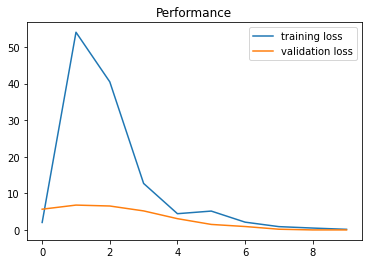

total allocated gpu memory (pytorch): 0


In [ ]:
training_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

training_losses, validation_losses, model = train(model_, loss_fn, optimizer, 
                                                  training_loader, val_loader, device=device,
                                                  return_model=True, epochs=10, lr=1e-3)

plt.title('Performance')
plt.plot(training_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend()
plt.show()

print('total allocated gpu memory (pytorch):', torch.cuda.memory_allocated())

In [ ]:
print("Training report")
train_report = evaluate(train_dataset, model, device=device, batch_size=512)
print("Validation report")
val_report = evaluate(val_dataset, model, device=device, batch_size=512)

  0%|          | 0/1 [00:00<?, ?it/s]

Training report


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.778     0.875        18
           1      0.984     1.000     0.992       239

    accuracy                          0.984       257
   macro avg      0.992     0.889     0.933       257
weighted avg      0.985     0.984     0.984       257

Validation report


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000        17

    accuracy                          1.000        19
   macro avg      1.000     1.000     1.000        19
weighted avg      1.000     1.000     1.000        19



### Using GradCAM
Since we already prepared a helper function for that, using GradCAM will be pretty simple.

In [ ]:
# set the layers you want to visualize
cnn_layers = [model.cnn_block1,  model.cnn_block2, model.cnn_block3]

val_dataset = val_dataset

# We have to specify the target we want to generate the class activation maps for.
# If the target is None, the highest scoring category will be used for every image in the batch.
# I am using ClassifierOutputSoftmaxTarget, it automatically applies softmax to the model outputs.
# it is also possible to define your own custom targets. 

targets = [ClassifierOutputSoftmaxTarget(i) for i in range(10)]

# You can also pass aug_smooth=True and eigen_smooth=True to apply smoothing.
gradcam(model, GradCAM, cnn_layers, targets, val_dataset, aug_smooth=True, eigen_smooth=True) #use_cuda=True)
print('total allocated gpu memory (pytorch):', torch.cuda.memory_allocated())


In [ ]:
# You can also pass aug_smooth=True and eigen_smooth=True to apply smoothing.
gradcam(model, GradCAM, cnn_layers, targets, val_dataset, aug_smooth=True, eigen_smooth=True) #use_cuda=True)
print('total allocated gpu memory (pytorch):', torch.cuda.memory_allocated())

# Az inja:

In [ ]:
# read the training and test datasets
DATASET_PATH = '/Users/azadehbaghdadi/Desktop/New research-CNN/Project/Data/sample/train'
# start by importing the datasets as dataframes
train_csv = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
test_csv = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))

# split the training dataset to construct a validation set
train_set, val_set = train_test_split(train_csv, test_size=.2)
test_set = test_csv.copy()


print('Train dataset:')
display(train_set.sample(5))
print('Validation dataset:')
display(val_set.sample(5))
print('Test dataset:')
display(test_set.sample(5))

print("Total samples in training data:", len(train_set))
print("Total samples in validation data:", len(val_set))
print("Total samples in test data:", len(test_csv))


In [ ]:

class MNISTDataset(Dataset):
    """Simple Dataset class for MNIST
    
    Simply decides if the dataset is for training or testing by checking the number of columns in the dataframe.
    
    Uses the`_initialize` method to reshape and define the input and target data
    """
    def __init__(self, dataframe, transformations=None):
        self._dataframe = dataframe
        self.transformations = transformations
        self.inputs = None
        self.targets = None
    
        if dataframe.shape[1] == 785: # if it has one more column besides the pixels, it is the training set
            self.dataset_type = 'training'
        else:
            self.dataset_type = 'test'

        self._initialize()
    
    def _initialize(self):
        if self.dataset_type == 'training':
            self.inputs = self._dataframe.iloc[:, 1:].values.reshape(-1,1, 28, 28)
            self.targets = self._dataframe.iloc[:, 0].values
        else:
            self.inputs = self._dataframe.values.reshape(-1, 1, 28, 28)
    
    def __len__(self):
        return len(self._dataframe)
    
    def __getitem__(self, idx):
        x = self.inputs[idx]
        if self.transformations:
            x = self.transformations(x)
        else:
            x = x/255.
            x = torch.tensor(x, dtype=torch.float32)
        
        
        if self.dataset_type == 'training':
            y = self.targets[idx]
            y = torch.tensor(y, dtype=torch.long)
            return x,y
        else:
            return x
    


train_dataset = MNISTDataset(train_set)
show(train_dataset)


In [ ]:

test_dataset = MNISTDataset(test_set)
val_dataset = MNISTDataset(val_set)


In [ ]:
# since the dataset is in a dataframe, we can apply the preprocessing pipeline to the dataframe
# then we can get the dataset for training

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [ ]:
show(train_loader.dataset)

In [ ]:
show(test_loader.dataset)


# Ta inja